In this notebook we visualize the attention between subjects, objects and predicates in clauses in Biblical Hebrew that contain each of these three phrases. At the same time, subject, object and predicate should consist of one word each, to simplify the task. 

BERT models return:

* outputs[0]: logits, 
* outputs[1]: hidden_states 
* outputs[2]: attentions



https://www.kdnuggets.com/how-to-visualize-model-internals-and-attention-in-hugging-face-transformers

In [3]:
import itertools

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import AutoTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from datasets import Dataset, DatasetDict

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


In [4]:
import torch
torch.cuda.empty_cache() 

In [5]:
#### First collect clauses that contain Subject, Object and Predicate that consist of only one word, and get the indices of these words on the clause.

In [6]:
def get_phrase_indices(cl):
    words = L.d(cl, 'word')
    funcs_seq = ''
    for w in words:
        trailer = ' ' if F.trailer.v(w) else ''
        func = F.function.v(L.u(w, 'phrase')[0])
        funcs_seq += func + trailer

    funcs_split = funcs_seq.split()
    subj_index = None
    objc_index = None
    pred_index = None
    for idx, f in enumerate(funcs_split):
        if 'Subj' in f:
            subj_index = idx
        elif 'Objc' in f:
            objc_index = idx
        elif 'Pred' in f:
            pred_index =idx
    return subj_index, objc_index, pred_index
        

In [7]:
subj_obj_clauses = {}
phrase_indices = {}

for cl in F.otype.s('clause'):
    phrases = L.d(cl, 'phrase')
    phrase_funcs = [F.function.v(phr) for phr in phrases]
    if 'Subj' in phrase_funcs and 'Objc' in phrase_funcs and 'Pred' in phrase_funcs:
        three_conditions = 0
        for phr in phrases:
            if F.function.v(phr) in {'Subj', 'Objc', 'Pred'} and len(L.d(phr, 'word')) == 1:
                three_conditions += 1
        if three_conditions == 3:
            heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in L.d(cl, 'word')]).strip()
            subj_obj_clauses[cl] = heb_text
            s_ind, o_ind, p_ind = get_phrase_indices(cl)
            phrase_indices[cl] = (s_ind, o_ind, p_ind)
                

In [8]:
# available models:

# avichr/heBERT
# dicta-il/dictabert
# dicta-il/BEREL
# dicta-il/BEREL_2.0
# onlplab/alephbert-base


In [9]:
model_name = 'dicta-il/BEREL_2.0'

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = BertForMaskedLM.from_pretrained(model_name,
                                        output_hidden_states=True, 
                                        output_attentions=True).to(device)

model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [12]:
def get_model_outputs(model, inputs):
    outputs = model(**inputs)
    return outputs

### First, we visualize all 12 attention head outputs of the first layer of one clause

In [13]:
tokenized_inputs = tokenizer('ויקרא אלהים לאור יום', max_length=128, truncation=True, padding=True, return_tensors="pt")
tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
with torch.no_grad():
    outputs = get_model_outputs(model, tokenized_inputs)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [14]:
lhs = outputs[1][-1]
lhs.shape

torch.Size([1, 6, 768])

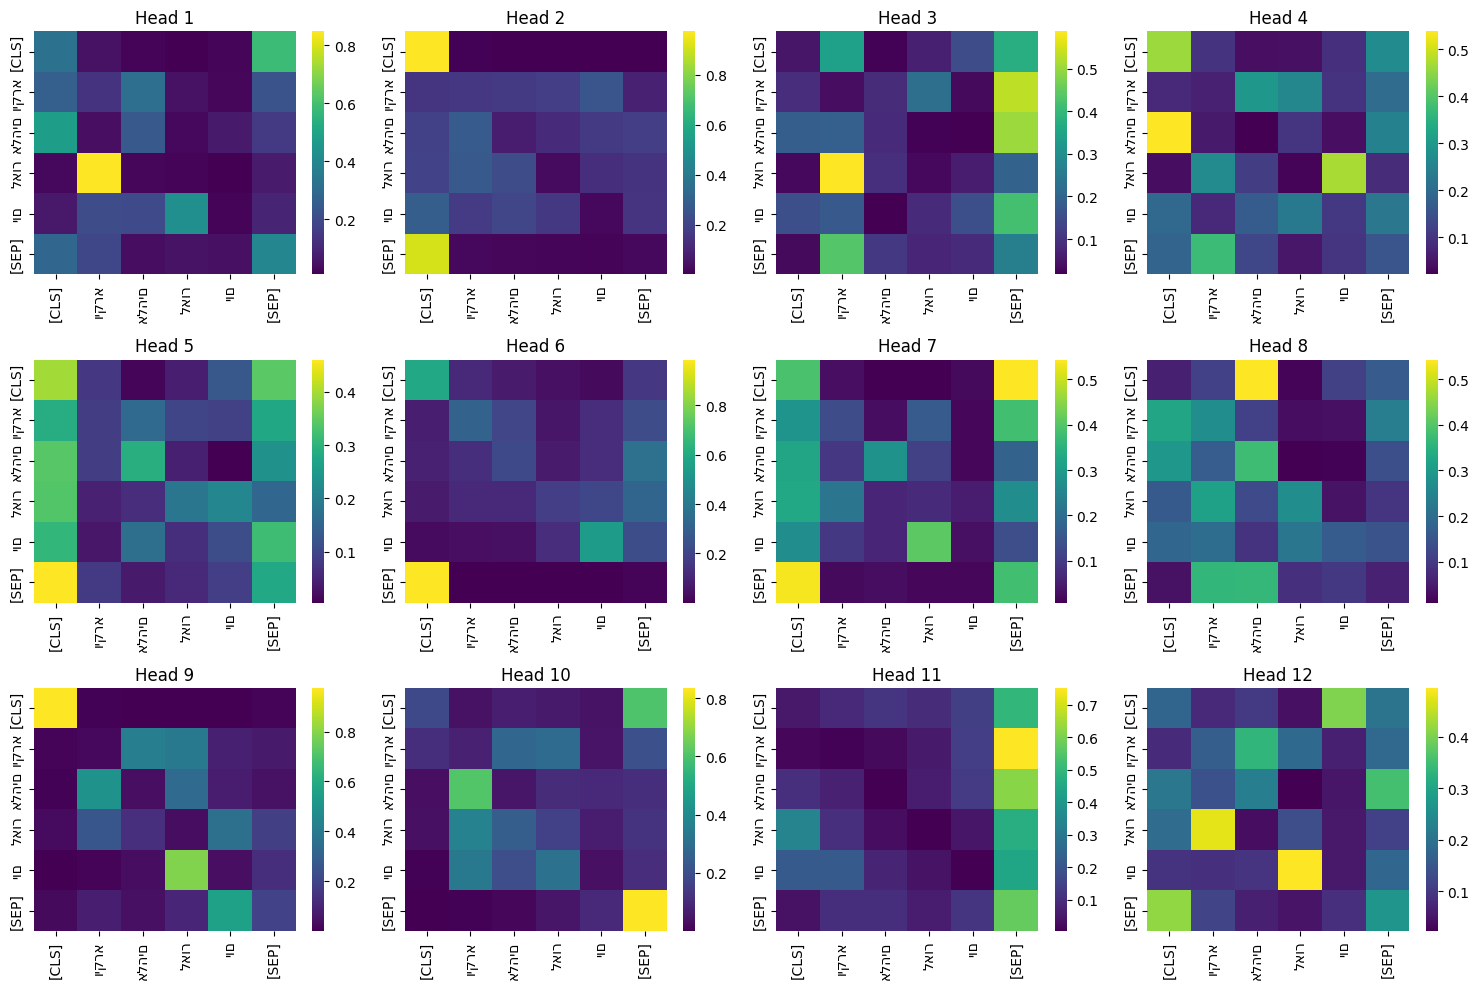

In [15]:
attention = outputs[2]

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    sns.heatmap(attention[0][0][i].detach().cpu().numpy(), ax=ax, cmap="viridis",
                xticklabels=tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0]),
                yticklabels=tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0])
               )
    ax.set_title(f"Head {i+1}")
plt.tight_layout()
plt.show()

In [16]:
# rowsums of attention are 1
attention[2][0, 1].sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')

In [17]:
def get_detailed_attention_head_output(phr_ids, attention_head_output):
    subj_idx = phr_ids[0] + 1
    obj_idx = phr_ids[1] + 1
    pred_idx = phr_ids[2] + 1

    so_attn = attention_head_output[subj_idx, obj_idx]
    sp_attn = attention_head_output[subj_idx, pred_idx]

    os_attn = attention_head_output[obj_idx, subj_idx]
    op_attn = attention_head_output[obj_idx, pred_idx]

    ps_attn = attention_head_output[pred_idx, subj_idx]
    po_attn = attention_head_output[pred_idx, obj_idx]
    return so_attn, sp_attn, os_attn, op_attn, ps_attn, po_attn

In [18]:
n_layers = 12
n_heads = 12

attention_scores = np.zeros((n_layers, n_heads, len(subj_obj_clauses), 6))

dissimilar_words_and_tokens = 0

for cl_enum, (cl_id, text) in enumerate(subj_obj_clauses.items()):
   
    phr_ids = phrase_indices.get(cl_id, None)
    tokenized_inputs = tokenizer(text, max_length=128, truncation=True, padding=True, return_tensors="pt")
    tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}

    num_tokens = len(tokenized_inputs['input_ids'][0]) - 2
    if len(text.split()) != num_tokens:
        dissimilar_words_and_tokens += 1
        continue
    
    with torch.no_grad():
        outputs = get_model_outputs(model, tokenized_inputs)
        
        attention = outputs[2]
        for layer_idx in range(12):
            attention_one_layer = attention[layer_idx]
            for attn_head_idx in range(12):
                one_head_attn = attention_one_layer[0][attn_head_idx]
                so_attn, sp_attn, os_attn, op_attn, ps_attn, po_attn = get_detailed_attention_head_output(phr_ids, one_head_attn)

                attention_scores[layer_idx, attn_head_idx, cl_enum, 0] = so_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 1] = sp_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 2] = os_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 3] = op_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 4] = ps_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 5] = po_attn

In [19]:
dissimilar_words_and_tokens

251

In [20]:
attention_labels = ['SO','SP','OS','OP','PS','PO']

In [21]:
# Scores for each layer:

# sum over all heads and all texts
each_layer_means = np.apply_over_axes(np.sum, attention_scores, [1,2])
each_layer_means = np.squeeze(each_layer_means)

## Figure 2.

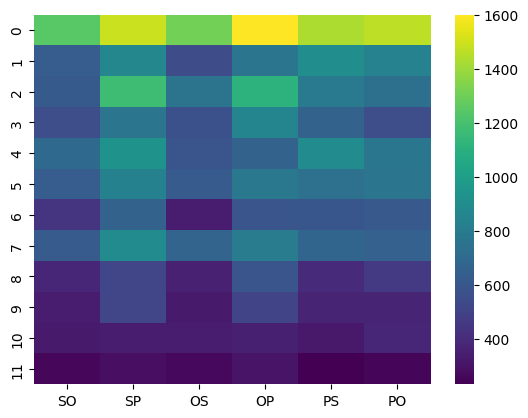

In [22]:
sns.heatmap(each_layer_means, cmap="viridis",
                xticklabels=attention_labels,
                yticklabels=list(range(12))
               )

plt.savefig('SPO_clauses_layers.png')

In [23]:
# Scores for each head

In [24]:
# sum over all layers and all texts
each_head_means = np.apply_over_axes(np.sum, attention_scores, [0,2])
each_head_means = np.squeeze(each_head_means)

# Figure 3.

<Axes: >

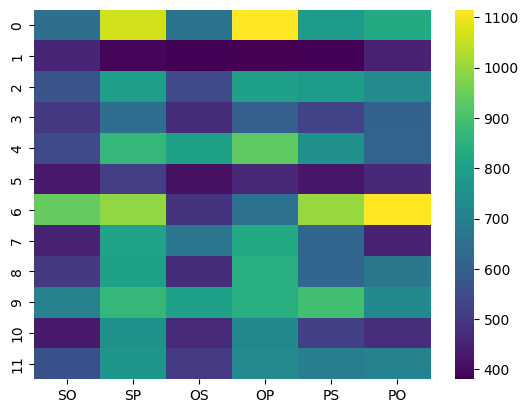

In [25]:
sns.heatmap(each_head_means, cmap="viridis",
                xticklabels=attention_labels,
                yticklabels=list(range(12))
               )